In [117]:
import numpy as np
import cmath, math
import matplotlib.pyplot as plt
import scipy.io
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn import svm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip "/content/drive/MyDrive/BCICIV_1_mat.zip"

Archive:  /content/drive/MyDrive/BCICIV_1_mat.zip
  inflating: BCICIV_calib_ds1a.mat   
  inflating: BCICIV_calib_ds1b.mat   
  inflating: BCICIV_calib_ds1c.mat   
  inflating: BCICIV_calib_ds1d.mat   
  inflating: BCICIV_calib_ds1e.mat   
  inflating: BCICIV_calib_ds1f.mat   
  inflating: BCICIV_calib_ds1g.mat   
  inflating: BCICIV_eval_ds1a.mat    
  inflating: BCICIV_eval_ds1b.mat    
  inflating: BCICIV_eval_ds1c.mat    
  inflating: BCICIV_eval_ds1d.mat    
  inflating: BCICIV_eval_ds1e.mat    
  inflating: BCICIV_eval_ds1f.mat    
  inflating: BCICIV_eval_ds1g.mat    


Given are continuous signals of 59 EEG channels and, for the calibration data, markers that indicate the time points of cue presentation and the corresponding target classes.



In [4]:
mat = scipy.io.loadmat('/content/BCICIV_calib_ds1b.mat')

In [5]:
#check that the chosen data are left and right hands 
mat['nfo']['classes']

array([[array([[array(['left'], dtype='<U4'), array(['right'], dtype='<U5')]],
              dtype=object)                                                   ]],
      dtype=object)

In [6]:
matArr = mat['mrk']['pos'][0][0][0]
y_target = mat['mrk']['y'][0][0][0]

In [7]:
#Channal of interest --> motor control is place on the frontal cortex, the frontal area of which 
# more close to central than other ones 
mat['nfo']['clab'][0][0][0][9:24]

array([array(['FC5'], dtype='<U3'), array(['FC3'], dtype='<U3'),
       array(['FC1'], dtype='<U3'), array(['FCz'], dtype='<U3'),
       array(['FC2'], dtype='<U3'), array(['FC4'], dtype='<U3'),
       array(['FC6'], dtype='<U3'), array(['CFC7'], dtype='<U4'),
       array(['CFC5'], dtype='<U4'), array(['CFC3'], dtype='<U4'),
       array(['CFC1'], dtype='<U4'), array(['CFC2'], dtype='<U4'),
       array(['CFC4'], dtype='<U4'), array(['CFC6'], dtype='<U4'),
       array(['CFC8'], dtype='<U4')], dtype=object)

**Publication:** https://www.researchgate.net/publication/321394237_Classification_of_Motor_Imagery_Based_EEG_Signals_Using_Sparsity_Approach
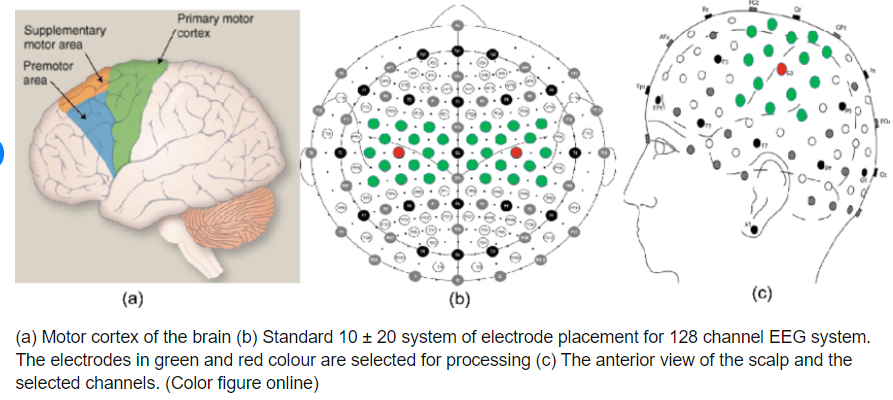

In [36]:
trials= []
for index in range(len(mat['mrk'][0][0][0][0])-1):
  trials.append(mat['cnt'][matArr[index]:matArr[index+1]].transpose()[9:24]* 0.1)

In [38]:
print(f'Number of trials --> {len(trials)}')
print(f'Shape of each trial (channals, time points) --> {np.shape(trials[0])}')
#That 800 are divide to 4 sec actual stimulus and 2 seconds blank screen 
# Cues were displayed for a period of 4s during which the subject was instructed to perform the cued motor imagery task. 
# These periods were interleaved with 2s of blank screen and 2s with a fixation cross shown in the center of the screen.
# 8 sec * sampling ratr (which is 100) = 800 time point for each trail 
# 59 is number of channals, we should choose from them which give us info about motion 

Number of trials --> 199
Shape of each trial (channals, time points) --> (15, 800)


In [39]:
#Define the time dimension 
fs= mat['nfo']['fs'][0][0][0][0]
maximun_time= np.shape(trials[0])[1]/fs
time= np.arange(0, maximun_time+(1/fs), 1/fs)
print(f'Number of time points --> {time.shape}')


Number of time points --> (801,)


In [40]:
#Different Trials, Same channal
def remove_outliers(dataFeature, crietion='medium'):
  dataFeature = dataFeature.transpose()
  if(crietion == 'medium'): 
    outliers_indeces = []
    for i in range(15):
      data = dataFeature[i]
    #Matrix of trial x channal
      df_ = np.argsort(data)
      q1, q3 = np.percentile(data[df_], [25, 75])
      iqr = q3 - q1
      lower_bound = q1 - (1.5 * iqr)
      upper_bound = q3 + (1.5 * iqr)
      outliers_indeces.append( [x for x in df_ if data[x] < lower_bound or data[x] > upper_bound])
    return outliers_indeces

In [96]:
#I took only the first 400 time points as they are when the cues were displayed on the screen. 

averagedTrails = np.empty((199,15))
for i in range(199):
  averagedTrails[i] =np.mean(trials[i].transpose()[:400].transpose(), axis=1)

varTrails = np.empty((199,15))
for i in range(199):
  varTrails[i] =np.var(trials[i].transpose()[:400].transpose(), axis=1)

print(f'Shape of the extracted feactures from the time dimension {varTrails.shape}')

Shape of the extracted feactures from the time dimension (199, 15)


In [97]:
returned=remove_outliers(varTrails)
setZero =np.zeros((199, 15))
for index , mat in enumerate(returned):
  for matValue in mat:
    setZero[matValue][index]=1

In [98]:
perfect_trials  = [index for index, matZero in enumerate(setZero) if np.sum(matZero)==0]
print(f'The non-outlier trials length is {len(perfect_trials)}')
print(f'Number of trials for each class after remoing the outliers,\nClass -1 {np.where(y_target[perfect_trials]==-1)[0].shape[0]} \nClass  1 {len(perfect_trials) - np.where(y_target[perfect_trials]==-1)[0].shape[0] }' )
#Although the used method of dealing with outliers, which is removing them from data, does not cause any unbalanced-classes, 
#it is not recommended. 

The non-outlier trials length is 156
Number of trials for each class after remoing the outliers,
Class -1 82 
Class  1 74


In [99]:

X_train, X_test, y_train, y_test = train_test_split(varTrails[perfect_trials], y_target[perfect_trials], test_size=0.3, random_state=0)

In [100]:
def decide(X):
    X [X < 0] = -1
    X [X >= 0] = 1       
    return X

In [88]:
reg = LinearRegression().fit(X_train, y_train)
accuracy_score(y_test, decide(reg.predict(X_test)))
#0.425531914893617 with normalization  varTrials
#0.40425531914893614 without normalization varTrials
#0.44680851063829785 without normalization averagedTrails


0.44680851063829785

In [101]:

clf = svm.SVC(C=0.5, random_state=42)
scores = cross_val_score(clf, X_train, y_train, cv=5)
scores

array([0.63636364, 0.54545455, 0.72727273, 0.63636364, 0.57142857])

# NN model

In [ ]:
#A bad idea beacuse is very small but I will not create it as deep as it may seem 
import torch 
import torch.nn.functional as F


class net(torch.nn.Module):
  def __init__(self):
    super(net, self).__init__()
    self.layer1 = torch.nn.Linear(15, 5)
    self.layer2 = torch.nn.Linear(5, 1)

  def forward(self, x):
    x = self.layer1(x)
    x = F.tanh(x)
    x = self.layer1(x)
    x = F.sigmoid(x)

    return x

myNet = net()
optimizer = torch.optim.SGD(myNet.parameters(), lr= 0.001)

Suggestions to apply 
1. A Filtering Phase (mean, bandPass filtering)
2. Normalization --> did not give the desired outcomes
3. Diffferent Ways to choose the channal of interest (learn the topological feature using mathematical concepts or GNN)
4. Don't remove outliers, instead replace it with other values
5. Classify on the frequency domain instead of the time domain --> gave better results
6. Different Models.


# Classify in the frequency domain 

In [58]:

class Signal:
    def __init__(self, signal): #Signal is a vector of values
        self.signal= signal
        self.N =len(signal)
        self.coeff = [] #Array of tuple, [(Real, Imaginary)]
        self.nyquist = self.N/2 

    def fourier_transofrm(self, diffFreq=0):
        print(self.nyquist)
        if(diffFreq==0):
            self.diffFreq=self.N
        complex_sine_wave_t = np.arange(0, self.N)/self.N  #A vector of time with a samiliar sampling rate to be used when generating each sin 
        self.fr = np.arange(0, self.diffFreq)  #Number of sin signals -with different frequencies- that can be combined to produce the original signal. 
        for i in range(len(self.fr)):
            complex_sine_wave = [cmath.exp(-2*math.pi*1j*self.fr[i]*complex_sine_wave_t[k]) for k in range(len(complex_sine_wave_t))] #generate signal with a specific frequency 
            self.coeff.append(np.dot(complex_sine_wave, self.signal)) #Array of tuple, [(Real, Imaginary) of the those different frequencies]
            #Then we'll get the contribution of each sin in producing the orignial one 
        return self.coeff, self.fr


    def find_frequancy_magnitude_contribution(self):
        #Take the absoluate to get mag
        pts_hz = self.fr[0:int(self.nyquist)]
        normalized_coeff = np.array(self.coeff)/self.N 
        self.magnitude = abs(normalized_coeff)
        self.magnitude = abs(normalized_coeff)*2
        plt.plot(pts_hz, self.magnitude[0:len(pts_hz)]) 
        

    
    def reconstruct(self):
        normalized_coeff = np.array(self.coeff)/self.N 
        complex_sine_wave_t = np.arange(0, self.N)/self.N
        reconstructed = np.zeros(self.N)
        for i in range (len(self.fr)):
            reconstructed = reconstructed + [normalized_coeff[i] * cmath.exp(2*cmath.pi*1j*self.fr[i]*complex_sine_wave_t[j]) for j in range(len(complex_sine_wave_t))]

        plt.plot(complex_sine_wave_t, reconstructed)



In [61]:
varTrails.shape

(156, 15)

78.0


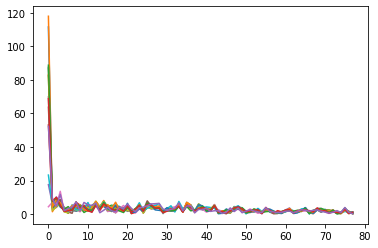

In [76]:
si =Signal(averagedTrails[perfect_trials])
coeff, fr = si.fourier_transofrm()
si.find_frequancy_magnitude_contribution()

In [77]:
si.magnitude.shape

(156, 15)

In [78]:
X_train, X_test, y_train, y_test = train_test_split(si.magnitude, y_target[perfect_trials], test_size=0.3, random_state=0)
reg = LinearRegression().fit(X_train, y_train)
accuracy_score(y_test, decide(reg.predict(X_test)))
#0.5957446808510638 --> averagedTrails in frequency domain 
#0.46808510638297873 --> varTrials in frequency domain 

0.5957446808510638

# Individuals 

In [114]:
def model_for_each_person(letter, feature_based='mean'):
  mat = scipy.io.loadmat('/content/BCICIV_calib_ds1'+letter+'.mat')
  matArr = mat['mrk']['pos'][0][0][0]
  y_target = mat['mrk']['y'][0][0][0]

  trials= []
  for index in range(len(mat['mrk'][0][0][0][0])-1):
    trials.append(mat['cnt'][matArr[index]:matArr[index+1]].transpose()[9:24]* 0.1)

  print(f'Number of trials --> {len(trials)}')
  print(f'Shape of each trial (channals, time points) --> {np.shape(trials[0])}')

  #I took only the first 400 time points as they are when the cues were displayed on the screen. 
  averagedTrails = np.empty((199,15))
  for i in range(199):
    averagedTrails[i] =np.mean(trials[i].transpose()[:400].transpose(), axis=1)

  varTrails = np.empty((199,15))
  for i in range(199):
    varTrails[i] =np.var(trials[i].transpose()[:400].transpose(), axis=1)
    if(feature_based== 'mean'):
      featureTrial = averagedTrails
    else:
      featureTrial = varTrails
  print(f'Shape of the extracted feactures from the time dimension {featureTrial.shape}')

  returned=remove_outliers(featureTrial)
  setZero =np.zeros((199, 15))
  for index , mat in enumerate(returned):
    for matValue in mat:
      setZero[matValue][index]=1

  perfect_trials  = [index for index, matZero in enumerate(setZero) if np.sum(matZero)==0]
  print(f'The non-outlier trials length is {len(perfect_trials)}')
  print(f'Number of trials for each class after remoing the outliers,\nClass -1 {np.where(y_target[perfect_trials]==-1)[0].shape[0]} \nClass  1 {len(perfect_trials) - np.where(y_target[perfect_trials]==-1)[0].shape[0] }' )
  #Although the used method of dealing with outliers, which is removing them from data, does not cause any unbalanced-classes, 
  #it is not recommended. 

  
  X_train, X_test, y_train, y_test = train_test_split(featureTrial[perfect_trials], y_target[perfect_trials], test_size=0.3, random_state=0)
  #Classifiers
  reg = LinearRegression().fit(X_train, y_train)
  print(f'Accuracy of Linear Regression {accuracy_score(y_test, decide(reg.predict(X_test)))}')

  clf = svm.SVC(C=0.5, random_state=42)
  scores = cross_val_score(clf, X_train, y_train, cv=5)
  print(f'SVM scores {scores}')

In [115]:
persons = ['b', 'c', 'd', 'e', 'g']
for person in persons:
  print(f'Person {person}')
  model_for_each_person(person, 'var')
  print('\n')

Person b
Number of trials --> 199
Shape of each trial (channals, time points) --> (15, 800)
Shape of the extracted feactures from the time dimension (199, 15)
The non-outlier trials length is 156
Number of trials for each class after remoing the outliers,
Class -1 82 
Class  1 74
Accuracy of Linear Regression 0.40425531914893614
SVM scores [0.63636364 0.54545455 0.72727273 0.63636364 0.57142857]


Person c
Number of trials --> 199
Shape of each trial (channals, time points) --> (15, 800)
Shape of the extracted feactures from the time dimension (199, 15)
The non-outlier trials length is 180
Number of trials for each class after remoing the outliers,
Class -1 90 
Class  1 90
Accuracy of Linear Regression 0.4444444444444444
SVM scores [0.42307692 0.4        0.48       0.52       0.36      ]


Person d
Number of trials --> 199
Shape of each trial (channals, time points) --> (15, 800)
Shape of the extracted feactures from the time dimension (199, 15)
The non-outlier trials length is 170
Num